# Predicting Age Group from health and nutritional status of Americans
        By: Forgive Agbesi, Jason Lee and Michael Hewlett

### Data set: National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset

# 1. Summary

In this analysis we explored the use of several classification models to predict whether a respondent is an adult or senior (essentially below or above age 65) based on their health and nutritional data. Our most promising model used Support Vector Classification (SVC) and had an overall accuracy of 0.83. While this appears promising, much of this accuracy was achieved by classifying most respondents as adults, since this was the majority class. Precision and recall for predicting the senior class was quite low (5/76 and 5/9 respectively). This suggests that the model has considerable room for improvement, which could be achieved through optimizing the hyperparameters and selecting models based on precision, recall, or f1 scores, rather than general accuracy. With the goal of correctly classifying each group, false positive and false negative errors are both equally important, applying class weighting is worth exploring in future research. Once the model performs better on those metrics, it would be worth exploring which health and nutritional features are most predictive of age, which could provide suggestions for strategic public health programs.

# 2. Introduction

While taking care of elders is a core value of many cultures, this is not a hallmark of many western societies, including the Unites States (Healthy Aging Center 2022). Is it possible that this is reflected in different health measures? Put another way, could we use health measures to predict whether an American is a senior or not?

Formally, the question this project seeks to answer is: Can information about the health and nutritional status of Americans be used to predict whether they are adults or seniors?

The dataset used to answer this question is the National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset (link: https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset). It was originally prepared for a research paper on predicting diabetes and cardiovascular disease in patients (Dinh and Miertschin 2016). The dataset's stated purpose was to assess the health and nutritional status of adults and children in the United States, however respondents were classified as either Adults (respondents under 65 years of age) or Seniors (respondents 65 years of age or older). Respondents were located in the United States and provided data through interviews, physical examinations, and laboratory tests to the National Center for Health Statistics (NCHS) (part of the Centers for Disease Control and Prevention (CDC)).

The dataset has 10 variables and 2278 rows, with each row representing a respondent. The variables are:
1. SEQN - The respondent ID aka sequence number
2. age_group - The respondent's age group (adult or senior)
3. RIDAGEYR - The respondent's age in years
4. RIAGENDR - The respondent's gender (1 represents Male, 2 represents Female)
5. PAQ605 - Whether the respondent engages in weekly moderate or vigorous physical activity (1 means they do, 2 means they don't)
6. BMXBMI - The respondent's body mass index
7. LBXGLU - The respondent's blood glucose after fasting
8. DIQ010 - Whether the respondent is diabetic (1 is yes, 2 is no)
9. LBXGLT - A measure of the respondent's oral health
10. LBXIN - The respondent's blood insulin levels

According to the dataset description, there are no missing values, though EDA found some unexpected values for physical activity and diabetic. Since no explanation was provided for these codes, we omitted these respondent's from our analysis.

# 3. Methods & Results

### 3.1 Description of methods
We loaded and cleaned the data, first renaming columns for clarity. We then found values for physical activity and diabetic variables that were not explained in the dataset's documentation and decided to remove observations with those values. Next we confirmed the that the dataset's description of no missing values was accurate, then split the data into training and test, and conducted EDA on the training set - including examining summary statistics of each variable and plotting their distributions.

For our analysis, we first transformed categorical variables with one hot encoding, and standardized the scales of numeric variables. Because there were no missing values, it was not necessary to do transformations for this. We then fit 3 models (a dummy classifier, a logistic regression, and SVC) to the training data, and selected SVC for our final analysis because it had the best mean cross-validation accuracy. Finally, we used our SVC model to predict the test data and visualized how the model performed on this data.

### 3.2 Imports & loading the data

In [1]:
import pandera as pa
import json
import logging
import pandas as pd
import numpy as np
import altair as alt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from deepchecks.tabular import Dataset

In [2]:
# Configure logging
logging.basicConfig(
    filename="validation_errors.log",
    filemode='w',
    format="%(asctime)s - %(message)s",
    level=logging.INFO
)

In [3]:
# Loading data
nhanes = fetch_ucirepo(id=887) 

original_df = nhanes.data.original

In [4]:
# Validate data and handle errors
schema = pa.DataFrameSchema(
    {
        "SEQN": pa.Column(float, pa.Check.ge(0)), # ID is greater than 0
        "age_group": pa.Column(str, pa.Check.isin(["Adult", "Senior"])),
        "RIDAGEYR": pa.Column(float, pa.Check.between(1, 130)), # Age between 1 and 130
        "RIAGENDR": pa.Column(float, pa.Check.isin([1, 2])), # Gender follows codes in description doc
        "PAQ605": pa.Column(float, pa.Check.isin([1, 2])), # Physical activity follows codes in description doc
        "BMXBMI": pa.Column(float, pa.Check.le(100)), #BMI
        "LBXGLU": pa.Column(float), # Units not available, no value range applied
        "DIQ010": pa.Column(float, pa.Check.isin([1, 2])), # Diabetic status follows codes in description doc
        "LBXGLT": pa.Column(float), # Units not available, no value range applied
        "LBXIN": pa.Column(float) # Units not available, no value range applied
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found.")
    ],
    strict=True #Raise error for any columns not defined in the schema
)

error_cases = pd.DataFrame()

try:
    validated_data = schema.validate(original_df, lazy=True)
except pa.errors.SchemaErrors as e:
    error_cases = e.failure_cases

    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

if not error_cases.empty:
    invalid_indices = error_cases['index'].dropna().unique()
    validated_data = (original_df.drop(index=invalid_indices).reset_index(drop=True)
    )

validated_data = validated_data.drop_duplicates().dropna(how='all')
validated_data.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


#### Inspecting errors
The dataset source stated that "gender", "physical_activity", and "diabetic" are binary features. However, "physical_activity", "diabetic" contained three unique values instead of two. According to the dataset's documentation, 'physical_activity' should only have 1 or 2 as values so rows containing 7 should be omitted. Similarly, 'diabetic' should only have 1 or 2 as values so rows containing 3 should be omitted.

As a result, we removed 59 observations from the dataset during validation (1 case where physical activity was "7" and the remaining cases where diabetic was set to "3").

### 3.3 Cleaning the data

In [5]:
# Listing variables
print(nhanes.variables)

        name     role         type demographic  \
0       SEQN       ID   Continuous        None   
1  age_group   Target  Categorical         Age   
2   RIDAGEYR    Other   Continuous         Age   
3   RIAGENDR  Feature   Continuous      Gender   
4     PAQ605  Feature   Continuous        None   
5     BMXBMI  Feature   Continuous        None   
6     LBXGLU  Feature   Continuous        None   
7     DIQ010  Feature   Continuous        None   
8     LBXGLT  Feature   Continuous        None   
9      LBXIN  Feature   Continuous        None   

                                         description units missing_values  
0                         Respondent Sequence Number  None             no  
1         Respondent's Age Group (senior/non-senior)  None             no  
2                                   Respondent's Age  None             no  
3                                Respondent's Gender  None             no  
4  If the respondent engages in moderate or vigor...  None           

#### Renaming columns and glancing at their values
We first renamed the columns of the data set to be more meaningful and easy to understand. Below is a short description of each column in the data set.

- RIDAGEYR: Respondent's Age
- RIAGENDR: Respondent's Gender (1 is Male / 2 is Female)
- PAQ605: Does the respondent engage in weekly moderate or vigorous-intensity physical activity (1 is yes / 2 is no)
- BMXBMI: Respondent's Body Mass Index
- LBXGLU: Respondent's Blood Glucose after fasting
- DIQ010: If the Respondent is diabetic (1 is yes / 2 is no)
- LBXGLT: Respondent's Oral
- LBXIN: Respondent's Blood Insulin Levels

In [6]:
# Checking out the feature columns
print("Table 1: The feature columns")
features = validated_data.drop(columns=["SEQN", "age_group", "RIDAGEYR"])
features

Table 1: The feature columns


,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92
...,...,...,...,...,...,...,...
2214,2.0,2.0,33.5,100.0,2.0,73.0,6.53
2215,1.0,2.0,30.0,93.0,2.0,208.0,13.02
2216,1.0,2.0,23.7,103.0,2.0,124.0,21.41
2217,2.0,2.0,27.4,90.0,2.0,108.0,4.99


In [7]:
# Renamed columns
print("Table 2: Renamed columns")
features.columns = ["gender", 
             "physical_activity", 
             "bmi", 
             "blood_glucose", 
             "diabetic", 
             "oral", 
             "blood_insulin"]
features.head()

Table 2: Renamed columns


,gender,physical_activity,bmi,blood_glucose,diabetic,oral,blood_insulin
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [8]:
# Checking out the target column
print("Table 3: Target column distribution")
target = validated_data["age_group"]
target.value_counts()

Table 3: Target column distribution


age_group
Adult     1873
Senior     346
Name: count, dtype: int64

### 3.4 Splitting the data set

Prior to conducting EDA, we split the data set to avoid looking at the test data and influence the training of our model. The training data is 80% of the original dataset, and the test data is 20%.

In [9]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

### 3.5 Conducting EDA on the training set

In [10]:
# Checking the number of observations in the training data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1775 entries, 1605 to 1346
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1775 non-null   float64
 1   physical_activity  1775 non-null   float64
 2   bmi                1775 non-null   float64
 3   blood_glucose      1775 non-null   float64
 4   diabetic           1775 non-null   float64
 5   oral               1775 non-null   float64
 6   blood_insulin      1775 non-null   float64
dtypes: float64(7)
memory usage: 110.9 KB


In [11]:
# Generating summary statistics of our variables.
print("Table 5: Summary Statistics")
nhanes_summary = X_train.describe()
nhanes_summary

Table 5: Summary Statistics


,gender,physical_activity,bmi,blood_glucose,diabetic,oral,blood_insulin
count,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000
mean,1.513803,1.821408,27.779549,99.113803,1.990423,113.892394,11.658721
std,0.499950,0.383118,7.148775,17.075649,0.097422,45.792843,9.540961
min,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,1.020000
25%,1.000000,2.000000,22.700000,91.000000,2.000000,87.000000,5.795000
50%,2.000000,2.000000,26.700000,97.000000,2.000000,104.000000,8.890000
75%,2.000000,2.000000,31.100000,103.000000,2.000000,129.000000,14.255000
max,2.000000,2.000000,70.100000,405.000000,2.000000,604.000000,102.290000


Since gender, physical_activity, and diabetic are categorical, only the mean and standard deviation from the table above are relevant for those columns. Body mass index values below 18 are considered underweight, and values over 40 are considered severely obese. We see that the middle 50% of values fall between 22.7 & 31.1, though the max is 70.1, which is concerningly high. Blood glucose, oral, and blood insulin have their own ranges, so it will likely be necessary to standardize these variables before fitting our model.

### 3.5.1 Validating Training Data

In [12]:
# Validation check: Target/response variable follows expected distribution

def validate_category_distribution(y_train, age_group_thresholds, tolerance):
    """
    Validate if a categorical variable's distribution meets specified thresholds with tolerance.

    Parameters:
    - y_train (pd.Series): The categorical variable (target/response variable).
    - age_group_thresholds (dict): Minimum and maximum proportion thresholds for each category.
    - tolerance (float): The tolerance to apply when checking proportions.

    Returns:
    - bool: True if the distribution meets the thresholds with tolerance, False otherwise.
    """
    value_counts = y_train.value_counts(normalize=True)  # Get proportions

    # Loop through each category and its thresholds
    for category, (min_threshold, max_threshold) in age_group_thresholds.items():
        proportion = value_counts.get(category, 0)  # Get proportion for the category
        
        # Check if the proportion is within the threshold range with tolerance
        if not (min_threshold - tolerance <= proportion <= max_threshold + tolerance):
            return False  # Return False if the proportion is out of the acceptable range
    
    return True  # Return True if all categories meet the criteria


age_group_thresholds = {"Adult": (0.2, 0.9), "Senior": (0.2, 0.9)}
tolerance = 0.05

# Validate the distribution
is_valid = validate_category_distribution(y_train, age_group_thresholds, tolerance)
print(is_valid)


True


In [13]:
# validate training data for anomalous correlations between target/response variable 
# and features/explanatory variables, 
# as well as anomalous correlations between features/explanatory variables
 
train_df = pd.concat([X_train, y_train], axis = 1)

# Specify categorical features if applicable
categorical_features = ["gender", "physical_activity", "diabetic"]

# Initialize Deepchecks Dataset
train_df_ds = Dataset(train_df, label="age_group", cat_features=categorical_features)

# Feature-Label Correlation Check
check_feat_tar_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_tar_corr_result = check_feat_tar_corr.run(dataset=train_df_ds)

# Feature-Feature Correlation Check
check_feat_feat_cor = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(threshold=0.92, n_pairs=0)
check_feat_feat_cor_result = check_feat_feat_cor.run(dataset=train_df_ds)

# Validate conditions
if not check_feat_tar_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_cor_result.passed_conditions():
    raise ValueError("Feature-Feature correlation exceeds the maximum acceptable threshold.")



### 3.6 Visualization for EDA

The distributions below show class imbalance, with very few seniors relative to adults in our dataset. Across numeric variables, mode values for seniors are less pronounced than they are for adult, though ranges seem similar. Seniors seem to have higher oral values and lower blood insulin values than adults. 

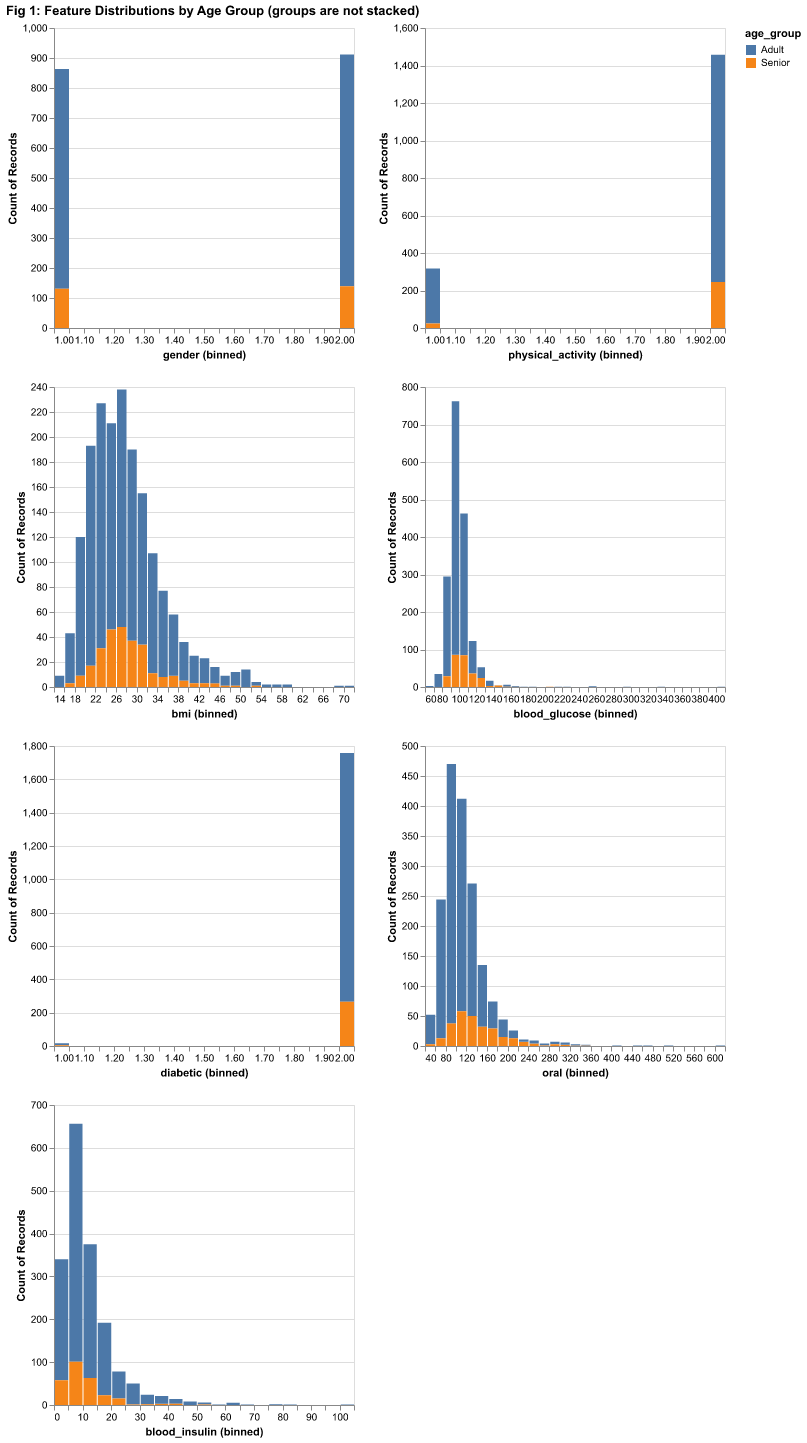

In [14]:
# Plotting the distributions for each variable
alt.renderers.enable('png')
features_list = X_train.columns.tolist()

alt.Chart(pd.concat([X_train, y_train], axis = 1)).mark_bar(opacity = 1).encode(
            x=alt.X(alt.repeat()).type('quantitative').bin(maxbins=40).stack(False),
            y='count()',
            color = 'age_group'
        ).repeat(
            features_list,
            columns = 2
        ).properties(
            title="Fig 1: Feature Distributions by Age Group (groups are not stacked)"
        )

### 3.6 Preprocessing features

#### Table 6: Feature types and planned transformations


| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| gender | one-hot encoding with "binary=True" | A binary feature with no missing values. 1 is Male, 2 is Female.|
| physical_activity | one-hot encoding with "binary=True" | A binary feature with no missing values. 1 is Yes, 2 is No. |
| bmi | scaling with `StandardScaler` | A numeric feature with no missing values.  |
| blood_glucose | scaling with `StandardScaler`  | A numeric feature with no missing values. |
| diabetic | one-hot encoding with "binary=True"  | A binary feature with no missing values. 1 is Yes, 2 is No. |
| oral | scaling with `StandardScaler`  | A numeric feature with no missing values. |
| blood_insulin | scaling with `StandardScaler`  | A numeric feature with no missing values. |

#### Preprocessing

In [15]:
# Transforming columns based on their type
numeric_features = ["bmi", "blood_glucose", "oral", "blood_insulin"]
binary_features = ["gender", "physical_activity", "diabetic"]

preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output = False,
                   drop='if_binary',dtype = int), binary_features),
    (StandardScaler(), numeric_features)
)

transformed_df = preprocessor.fit_transform(X_train)

### 3.7 Comparing classification models on Train data for best model

We compare a dummy classifier, logistic regression, and SVC model by mean cross validation score.

#### Baseline model

In [16]:
from sklearn.dummy import DummyClassifier
print("Table 7: DummyClassifier Cross validation results")

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy)
dc_results= cross_validate(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
dc_results_df = pd.DataFrame(dc_results)
dc_results_df

Table 7: DummyClassifier Cross validation results


,fit_time,score_time,test_score,train_score
0,0.004044,0.001910,0.847887,0.847887
1,0.002715,0.001479,0.847887,0.847887
2,0.002748,0.001790,0.847887,0.847887
3,0.002546,0.001457,0.847887,0.847887
4,0.002691,0.001600,0.847887,0.847887


#### Logistic regresion

In [17]:
from sklearn.linear_model import LogisticRegression
print("Table 8: LogisticRegrssor Cross validation results")

lr = LogisticRegression(random_state = 123)
lr_pipe = make_pipeline(preprocessor, lr)
lr_results= cross_validate(
    lr_pipe, X_train, y_train, cv=5, return_train_score=True
)
lr_results_df = pd.DataFrame(lr_results)
lr_results_df

Table 8: LogisticRegrssor Cross validation results


,fit_time,score_time,test_score,train_score
0,0.021243,0.001913,0.856338,0.842958
1,0.005428,0.001483,0.839437,0.846479
2,0.007295,0.001445,0.845070,0.846479
3,0.015024,0.005446,0.842254,0.843662
4,0.010523,0.001806,0.845070,0.845775


#### SVC model

In [18]:
from sklearn.svm import SVC
print("Table 9: SVC Cross validation results")

svc = SVC(random_state = 123)
svc_pipe = make_pipeline(preprocessor, svc)
svc_results= cross_validate(
    svc_pipe, X_train, y_train, cv=5, return_train_score=True
)
svc_results_df = pd.DataFrame(svc_results)
svc_results_df

Table 9: SVC Cross validation results


,fit_time,score_time,test_score,train_score
0,0.026567,0.012841,0.853521,0.851408
1,0.028394,0.012148,0.847887,0.854930
2,0.023694,0.012440,0.850704,0.851408
3,0.018905,0.012105,0.847887,0.856338
4,0.019677,0.012433,0.839437,0.853521


#### Comparing scores

In [19]:
print("Model mean CV scores:")

# Baseline validation score
dc_test_score = dc_results_df['test_score'].mean()
print(f'  Baseline: {round(dc_test_score, 5)}')

# LR mean validation score
lr_mean_test_score = lr_results_df['test_score'].mean()
print(f'  Logistic Regression: {round(lr_mean_test_score, 5)}')

# SVC mean validation score
svc_mean_test_score = svc_results_df['test_score'].mean()
print(f'  SVC: {round(svc_mean_test_score, 5)}')



Model mean CV scores:
  Baseline: 0.84789
  Logistic Regression: 0.84563
  SVC: 0.84789


### 3.8 Testing Best Model on Test Data

Since SVC had the best mean CV score, we selected it as our final model.

In [20]:
svc_pipe.fit(X_train,y_train)

Test_score = svc_pipe.score(X_test,y_test)

print(f'Model accuracy on test data: {round(Test_score, 3)}')

Model accuracy on test data: 0.831


#### Visualizing model performance

Fig 2: Confusion Matrix of best model on test data


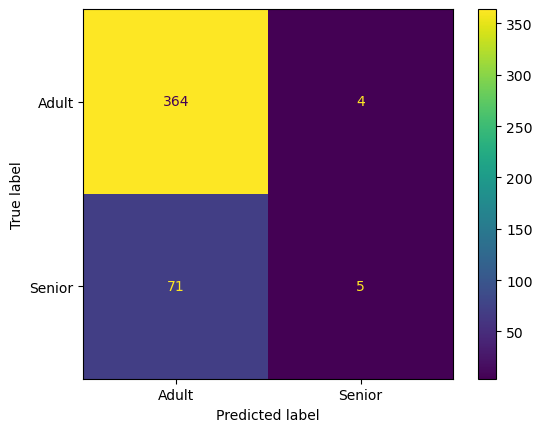

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay 
print("Fig 2: Confusion Matrix of best model on test data")

test_confMatrix = ConfusionMatrixDisplay.from_estimator(
    svc_pipe,
    X_test,
    y_test,
    values_format="d",
)
test_confMatrix

The confusion matrix shows that while the model score is 0.831, it does very poorly at recall (71 of 76 seniors are classified as adults) and quite poorly at precision (5/9 predicted seniors actually are seniors).

Fig 3: ROC curve of best model on test data


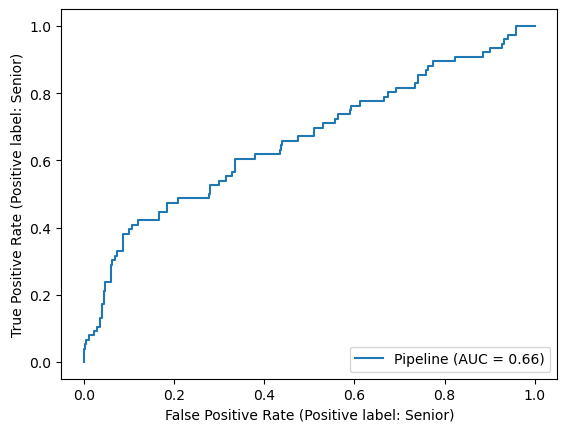

In [22]:
print("Fig 3: ROC curve of best model on test data")

RocCurveDisplay.from_estimator(
    svc_pipe,
    X_test,
    y_test,
    pos_label= "Senior",
);

This performance is reflected in the ROC curve above. While it can differentiate the positive class "Senior" from the negative class to some extent, the model struggles to achieve both high true positive rates and low false positive rates.

# Discussion

The question we sought to answer was "Can information about the health and nutritional status of Americans be used to predict whether they are adults or seniors?" Our results indicate that yes, age group can be predicted with moderate accuracy (roughly 83%) based on health and nutritional inputs, however there is considerable room for model improvement. 

We were initially surprised how high accuracy was without any hyperparameter tuning, and this turned out to be because the classes were imbalanced, meaning accuracy as a metric oversells the model's ability to distinguish the two groups. Since adults are the majority class, classifying most respondents as adults will give a high accuracy, but not be useful for identifying seniors. 

In future research, we would use a metric like f1 to account for the class imbalance and conduct hyperparameter optimization to improve the model's recall and precision. 

One question for future research is to identify which health and nutritional factors have the strongest predictive ability for age group. Answering that could indicate which public health interventions have the most potential to balance health outcomes across age groups in America.

# References

Healthy Aging Center. 2022. "Aging Around the World." Colorado State University. https://www.research.colostate.edu/healthyagingcenter/2022/01/28/aging-around-the-world/.

Dinh, Andrew, and Susan Miertschin. 2016. “A Data-Driven Approach to Predicting Diabetes and Cardiovascular Disease with Machine Learning.” Semantic Scholar. https://www.semanticscholar.org/paper/A-data-driven-approach-to-predicting-diabetes-and-Dinh-Miertschin/01af1548ff1f3661d8bb813e8c35ee219a79ca9f.

Mukhtar, Hamid and Sana Al Azwari. “Investigating Non-Laboratory Variables to Predict Diabetic and Prediabetic Patients from Electronic Medical Records Using Machine Learning.” (2021).

Papazafiropoulou, Athanasia K.. “Diabetes management in the era of artificial intelligence.” Archives of Medical Sciences. Atherosclerotic Diseases 9 (2024): e122 - e128.